# 🏦 Loan Approval Prediction – End-to-End ML Pipeline

## 🎯 Objective
Predict whether a loan will be approved (Y/N) using applicant information.

This notebook includes:
- Data loading
- Exploratory Data Analysis
- Preprocessing
- Model training with GridSearch
- Evaluation
- SHAP model explainability
- Model saving
- Sample prediction

In [1]:
# =========================
# 1) Imports
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

import shap
import joblib

In [14]:
# =========================
# 2) Load Dataset
# =========================

df = pd.read_csv("loan_data.csv")

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
# =========================
# 3) Basic EDA
# =========================

print("\nColumn Names:\n", df.columns)
print("\nData Types:\n", df.dtypes)

print("\nMissing Values:\n")
print(df.isnull().sum())

print("\nTarget Distribution:\n")
print(df["Loan_Status"].value_counts())


Column Names:
 Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

Data Types:
 Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Missing Values:

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype

In [7]:
# =========================
# 4) Data Cleaning
# =========================

# Remove ID column
df = df.drop("Loan_ID", axis=1)

# Clean target
df["Loan_Status"] = df["Loan_Status"].map({"Y": 1, "N": 0})

X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

In [8]:
# =========================
# 5) Train-Test Split
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [9]:
# =========================
# 6) Preprocessing & Model
# =========================

categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(exclude="object").columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=5000))
])

param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

Best Parameters: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV F1 Score: 0.8699456484348126


In [10]:
# =========================
# 7) Evaluation
# =========================

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Test Accuracy: 0.8536585365853658

Confusion Matrix:
 [[21 17]
 [ 1 84]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123

ROC-AUC Score: 0.8452012383900929


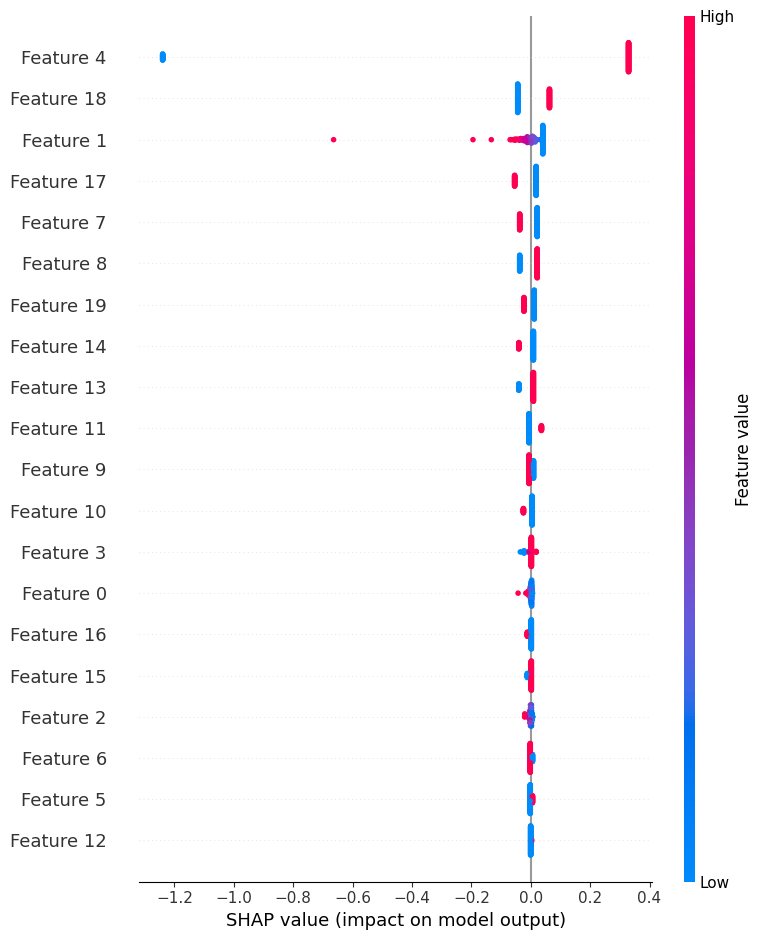

In [11]:
# =========================
# 8) SHAP Explanation
# =========================

# Transform test data
X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)

explainer = shap.LinearExplainer(
    best_model.named_steps["model"],
    X_test_transformed
)

shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(
    shap_values,
    X_test_transformed,
    show=True
)

In [12]:
# =========================
# 9) Save Model
# =========================

joblib.dump(best_model, "loan_approval_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [13]:
# =========================
# 10) Sample Prediction
# =========================

def predict_loan_status(input_dict):
    input_df = pd.DataFrame([input_dict])
    prediction = best_model.predict(input_df)[0]
    probability = best_model.predict_proba(input_df)[0][1]

    return {
        "Loan_Status_Prediction": int(prediction),
        "Approval_Probability": float(probability)
    }

sample_input = {
    "Gender": "Male",
    "Married": "Yes",
    "Dependents": "0",
    "Education": "Graduate",
    "Self_Employed": "No",
    "ApplicantIncome": 5000,
    "CoapplicantIncome": 0,
    "LoanAmount": 150,
    "Loan_Amount_Term": 360,
    "Credit_History": 1.0,
    "Property_Area": "Urban"
}

predict_loan_status(sample_input)

{'Loan_Status_Prediction': 1, 'Approval_Probability': 0.7465645569660835}